In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import os

In [6]:
FEMTO = '../../../data/10FEMTO/raw_data/Validation_set/'
POST_PROCESS = '../../../data/10FEMTO/processed_data/'
DATASET = [('Bearing1_1', True), ('Bearing1_2', True)]
# DATASET = [('Bearing1_3', False), ('Bearing1_4', True), ('Bearing1_5', True), ('Bearing1_6', True), ('Bearing1_7', True), ('Bearing2_3', False), ('Bearing3_1', False)]
LEN = 2560
WINDOW_SIZE = 40

In [7]:
class Process():
    def __init__(self, folders: str, window_size: int) -> None:
        self.folders = folders
        self.features = []
        self.Y = []
        self.train = None
        self.window_size = window_size

    def loop_folder(self):
        for (folder, is_train) in self.folders:
            self.features = []
            self.Y = []
            print(folder, is_train)
            try:
                self.train = is_train
                accs = os.listdir(FEMTO+folder)
                accs.sort()
                accs = [acc for acc in accs if acc.startswith('acc')]
                # accs = accs[:100]
                life = len(accs)
                for stamp, acc in enumerate(accs):
                    feature = self._extract_feature(f'{FEMTO}/{folder}/{acc}')
                    rul = (life - stamp) / life
                    self.features.append(feature)
                    self.Y.append(rul)
                self.features, self.Y = self._slide_window()
                self._save_data(folder)
                print(self.features.shape, self.Y.shape) 
            except Exception as e:
                print(e)
                print(folder)
    def _save_data(self, folder: str):
        np.save(f'{POST_PROCESS}{folder}/{folder}_train_X', self.features) if self.train else np.save(f'{POST_PROCESS}{folder}/{folder}_test_X', self.features)
        np.save(f'{POST_PROCESS}{folder}/{folder}_train_Y', self.Y) if self.train else np.save(f'{POST_PROCESS}{folder}/{folder}_test_Y', self.Y)

    def _extract_feature(self, acc: str):
        x = pd.read_csv(acc, header=None, sep=',', usecols=[4])
        # time zone
        x_abs = x.abs()
        x_avg = x.sum() / LEN
        mean_square_mean = ((x.apply(lambda x: x - x_avg)) ** 2).sum()
        p1 = x.min()
        p2 = x.max()
        p3 = x_abs.max()
        p4 = p2 - p1
        p5 = x_abs.sum() / LEN
        p6 = (x_abs.sum() ** 0.5 / LEN) * 2
        p7 = mean_square_mean / (LEN -1)
        p8 = (mean_square_mean / LEN) ** 0.5
        p9 = ((x ** 2).sum() / LEN) ** 0.5
        p10 = ((x.apply(lambda x: x - x_avg)) ** 3).sum() / ((LEN - 1) * (p8 ** 3))
        p11 = (LEN * p9) / x_abs.sum()
        p12 = p9 / p5
        p13 = p3 / p9
        p14 = p3 / p5
        p15 = p3 / p6
        p16 = p3 / (p9 ** 2)
        # frequency zone
        fft_result = np.fft.fft(x.to_numpy())
        N = len(fft_result)
        frequencies = np.fft.fftfreq(N)  # 采样频率为 2560 Hz
        amplitudes = np.abs(fft_result)
        plt.plot(amplitudes, label='Y', marker='s', markersize=1)
        plt.show()
        p17 = np.sum(amplitudes) / N
        p18 = np.sum(frequencies * amplitudes) / np.sum(amplitudes)
        p19 = (np.sum(frequencies ** 2 * amplitudes) / np.sum(amplitudes)) ** 0.5
        p20 = ((np.sum((frequencies - p18) ** 2 * amplitudes)) / np.sum(amplitudes)) ** 0.5

        return [p1.iloc[0], p2.iloc[0], p3.iloc[0], p4.iloc[0], p5.iloc[0], p6.iloc[0], 
                p7.iloc[0], p8.iloc[0], p9.iloc[0], p10.iloc[0], p11.iloc[0], p12.iloc[0], 
                p13.iloc[0], p14.iloc[0], p15.iloc[0], p16.iloc[0], p17, p18, p19, p20]
    
    def _slide_window(self):
        feature_windows = []
        y_windows = []
        for i in range(len(self.features) - self.window_size):
            feature_window = np.array(self.features)[i:i + self.window_size, :]
            y_window = np.array(self.Y)[i + self.window_size]
            feature_windows.append(feature_window)
            y_windows.append(y_window)
        return np.array(feature_windows), np.array(y_windows)

Bearing1_1 True


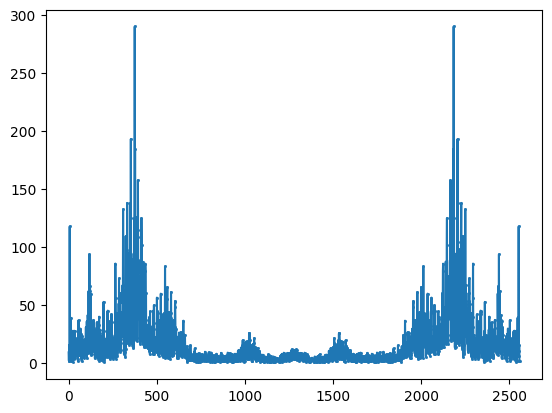

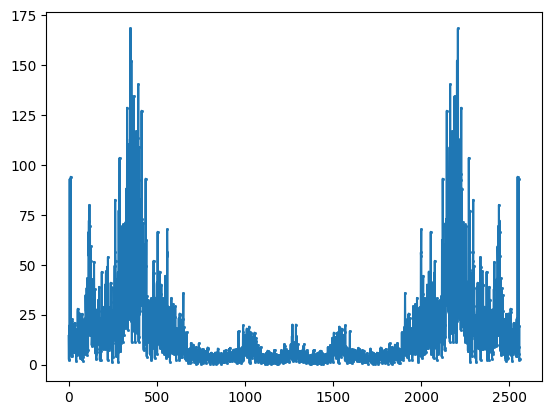

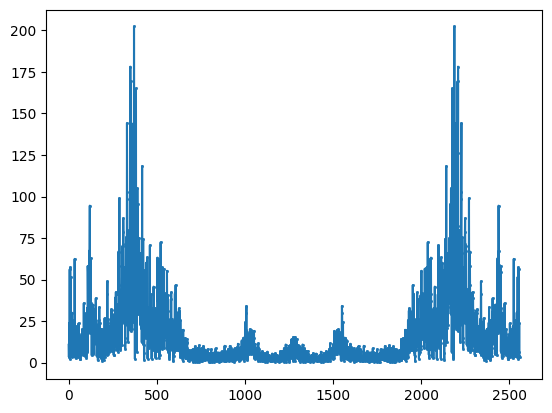

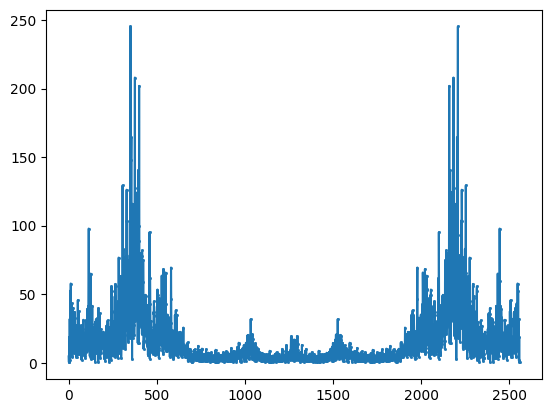

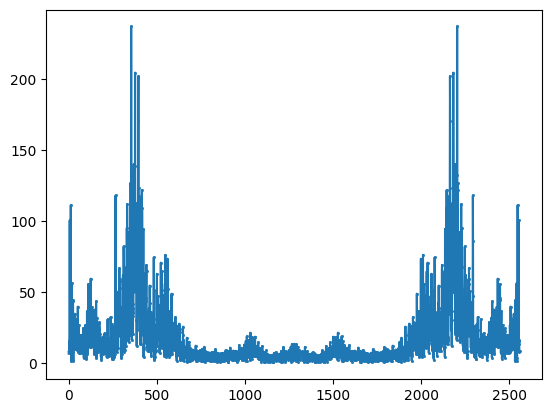

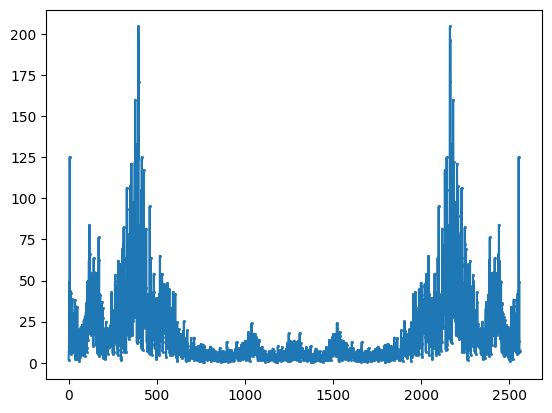

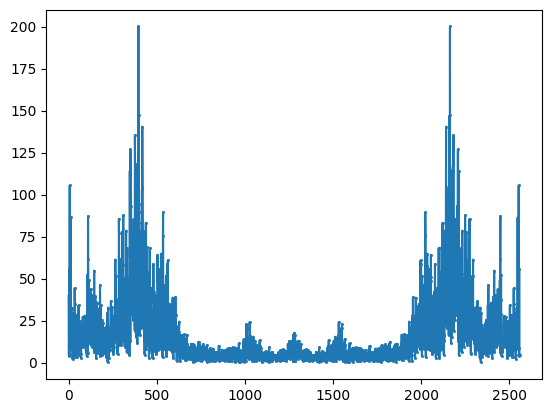

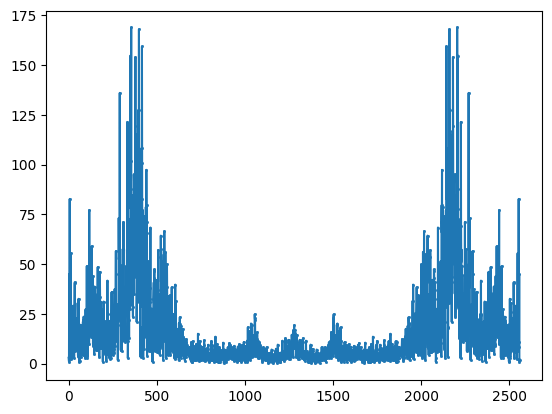

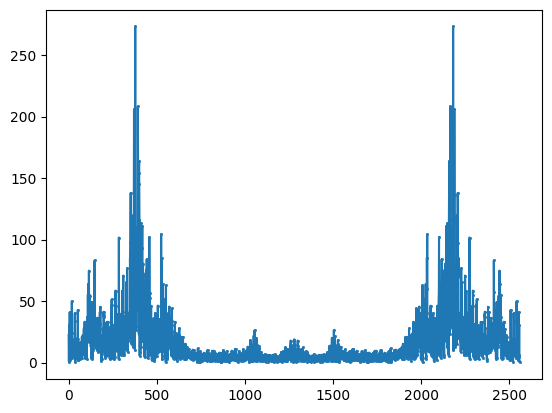

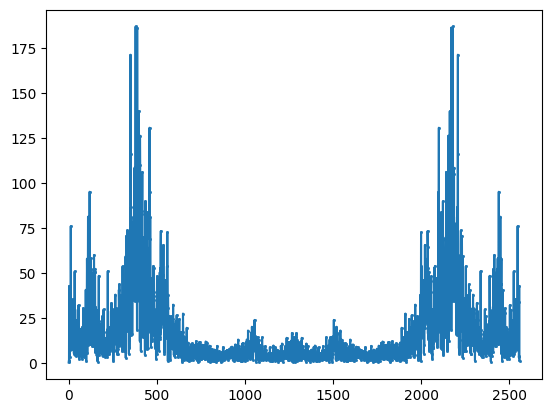

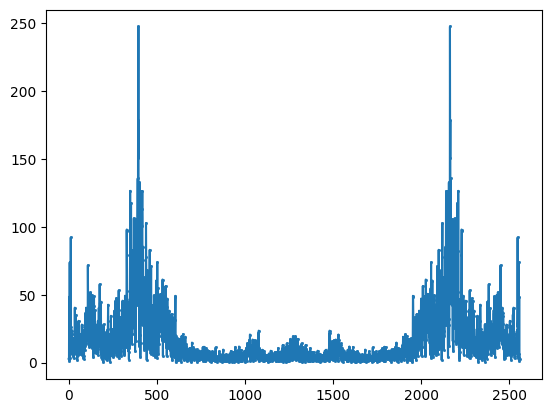

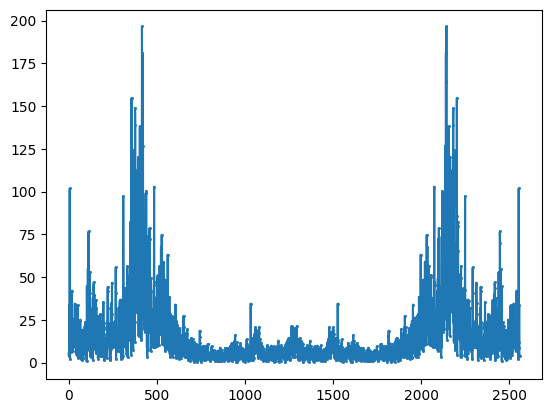

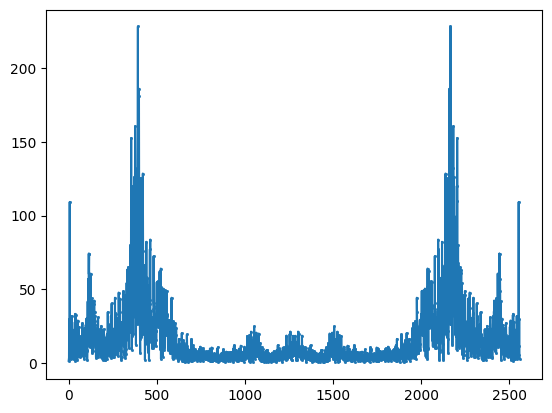

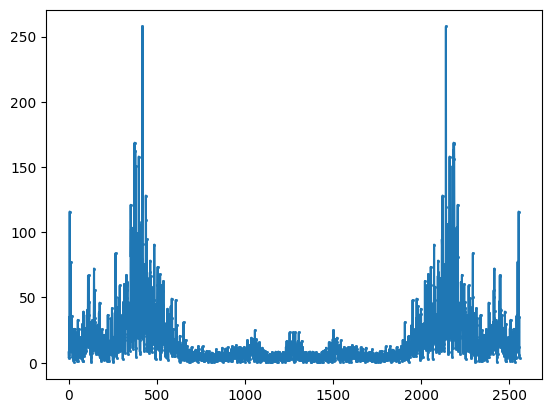

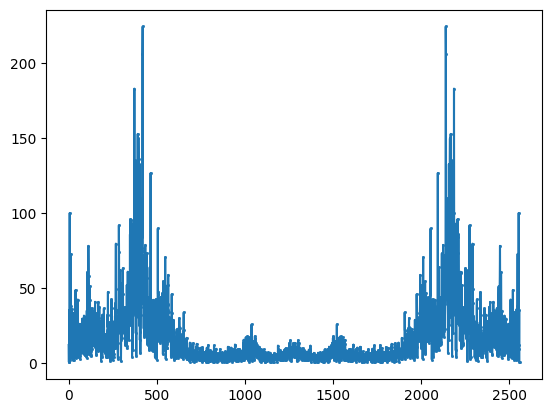

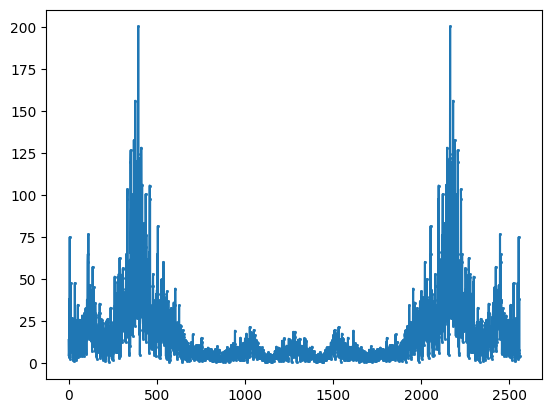

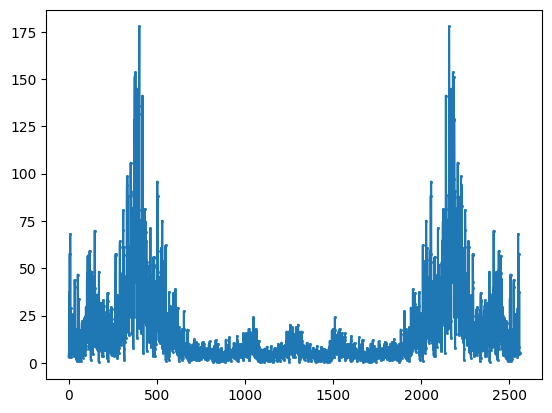

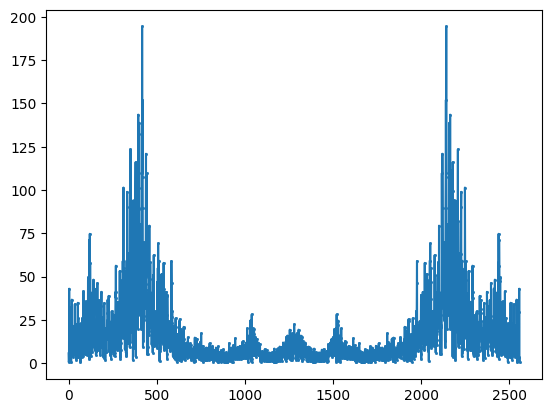

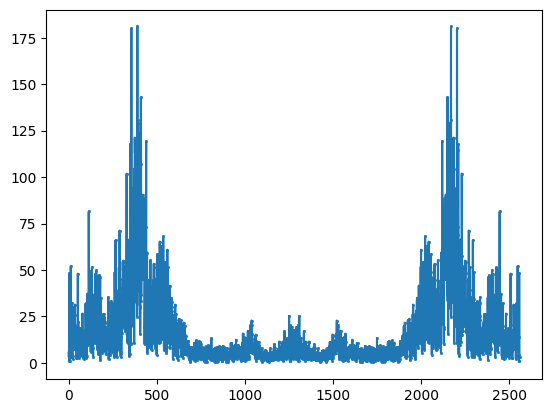

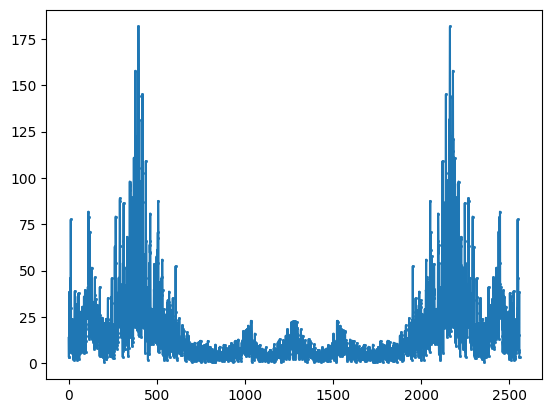

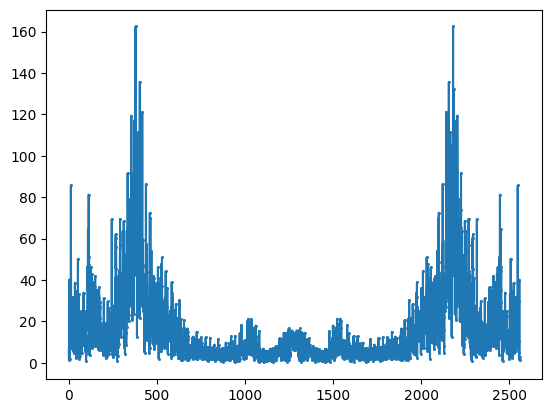

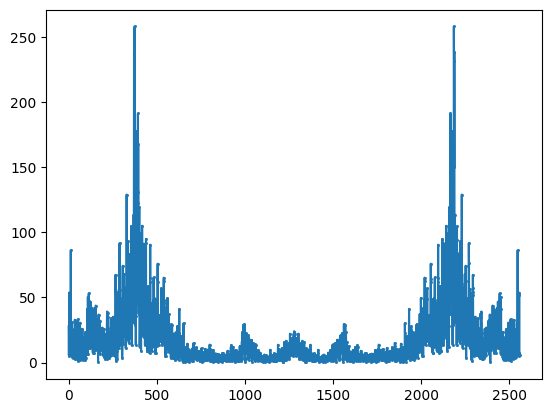

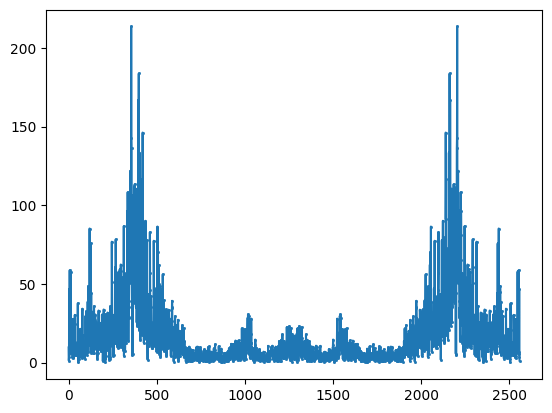

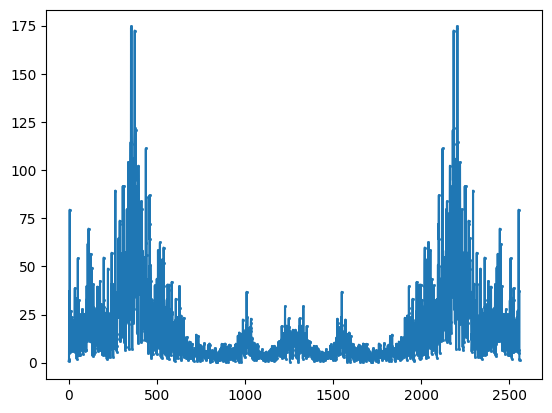

KeyboardInterrupt: 

In [8]:
process = Process(DATASET, WINDOW_SIZE)
process.loop_folder()
X = np.array(process.features)
Y = np.array(process.Y)
print(X.shape)
print(Y.shape)

In [7]:
x = pd.read_csv('../../../data/10FEMTO/raw_data/Validation_set/Bearing1_1/acc_02346.csv', header=None, sep=',', usecols=[4])
# time zone
x_abs = x.abs()
x_avg = x.sum() / LEN
mean_square_mean = ((x.apply(lambda x: x - x_avg)) ** 2).sum()
p1 = x.min()
p2 = x.max()
p3 = x_abs.max()
p4 = p2 - p1
p5 = x_abs.sum() / LEN
p6 = (x_abs.sum() ** 0.5 / LEN) * 2
p7 = mean_square_mean / (LEN -1)
p8 = (mean_square_mean / LEN) ** 0.5
p9 = ((x ** 2).sum() / LEN) ** 0.5
p10 = ((x.apply(lambda x: x - x_avg)) ** 3).sum() / ((LEN - 1) * (p8 ** 3))
p11 = (LEN * p9) / x_abs.sum()
p12 = p9 / p5
p13 = p3 / p9
p14 = p3 / p5
p15 = p3 / p6
p16 = p3 / (p9 ** 2)
# frequency zone
fft_result = np.fft.fft(x.to_numpy())
N = len(fft_result)
frequencies = np.fft.fftfreq(N, d=1)  # 采样频率为 2560 Hz
amplitudes = np.abs(fft_result)
p17 = np.sum(amplitudes) / N
p18 = np.sum(frequencies * amplitudes) / np.sum(amplitudes)
p19 = (np.sum(frequencies ** 2 * amplitudes) / np.sum(amplitudes)) ** 0.5
p20 = ((np.sum((frequencies - p18) ** 2 * amplitudes)) / np.sum(amplitudes)) ** 0.5